## Stereo Depth Estimation Demo

In [30]:
import cv2
import glob
import os
import numpy as np
from tqdm import tqdm

The following demo is meant to help you get a better understanding of dense stereo depth estimation. We will start with a cursory overview of the mathematics behind stereo depth estimation and then discuss and implement algorithms to get a dense depth map from two different images

### Overview of Stereo Depth Estimation

Stereo images are images taken at the same *y* and *z* coordinates and with the same roll, pitch, and yaw. The only difference between their location is the *x* value. To intuite how we get depth from these two images, imagine you are standing in a park with trees. TreeA is 1 meter in front of you and treeB is 100 meters in front of you. If you took a stereo image here, you would notice that treeA would seem to move a much larger distance between the images than treeB because treeA is closer.

### General Pipeline

In the below section, we will introduce a general pipeline for taking stereo images and extracting depth from those images.  
First, we will take a picture to obtain a stereo image pair.  
Second, we will perform some camera calibration and use this to process our stereo image pair.  
Third, we will run some matching algorithms for calculating dense correspondences between pixels.  
Fourth, from these correspondences and the camera intrinsics that we got from the camera calibration, we will be able to assign a depth value to each pixel.  

#### Setting up stereo image collection

First, we must create a process to take images from our stereo camera.

In [31]:
def save_stereo_img_left_and_right(stereo_img, i, object_name):
    # Separate into two images
    h, w, _ = stereo_img.shape
    mid = w // 2

    left_img = stereo_img[:, :mid]
    right_img = stereo_img[:, mid:]
    # Make folder names
    left_images_save_path = f"{object_name}_left_images"
    right_images_save_path = f"{object_name}_right_images"


    # Create the save path if it doesn't exist
    
    os.makedirs(left_images_save_path, exist_ok=True)
    os.makedirs(right_images_save_path, exist_ok=True)

    # Save
    left_img_file_name = f"{left_images_save_path}/left_img_{i + 1}.png"
    right_img_file_name = f"{right_images_save_path}/right_img_{i + 1}.png"

    # Save to file 
    cv2.imwrite(left_img_file_name, left_img)
    # print(f"Image {i + 1} captured and separated as {left_img_file_name}")
    cv2.imwrite(right_img_file_name, right_img)
    # print(f"Image {i + 1} captured and saved as {right_img_file_name}")


def list_available_cameras():
    # Try to open each camera index and print information
    for i in range(10):  # Try indices from 0 to 9
        cap = cv2.VideoCapture(i)
        if not cap.isOpened():
            break
        else:
            print(f"Camera Index {i}: {cap.get(cv2.CAP_PROP_FRAME_WIDTH)} x {cap.get(cv2.CAP_PROP_FRAME_HEIGHT)}")
            cap.release()

def capture_images(camera_index=0, num_images=10, save_path='captured_images'):
    print("Camera index: ", camera_index)
    # Create a VideoCapture object
    cap = cv2.VideoCapture(camera_index)
    width_resolution = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height_resolution = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    print(f"Camera width: {width_resolution}")
    print(f"Camera resolution: {height_resolution}")

    # Check if the camera is opened successfully
    if not cap.isOpened():
        print("Error: Could not open camera.")
        return

    # Create the save path if it doesn't exist
    os.makedirs(save_path, exist_ok=True)
    cv2.waitKey(500)
    print(f"Capturing {num_images} images from camera {camera_index}...")
    
    for i in range(num_images):
        # Capture frame-by-frame
        ret, frame = cap.read()

        # Display the frame
        cv2.imshow('Frame', frame)

        # Save the frame as an image
        image_filename = f"{save_path}/image_{i + 1}.png"
        cv2.imwrite(image_filename, frame)

        save_stereo_img_left_and_right(frame, i, save_path)

        print(f"Image {i + 1} captured and saved as {image_filename}")

        # Wait for a short time between captures (milliseconds)
        cv2.waitKey(2500)

    # Release the VideoCapture object
    cap.release()

    # Close all OpenCV windows
    cv2.destroyAllWindows()

if __name__ == "__main__":
    # Specify the camera index (0 by default, which is usually the built-in webcam)
    # You may need to change the index if you have multiple cameras
    camera_index = 0

    # Number of images to capture
    num_images = 15

    # Specify the folder to save the captured images
    save_path = 'null'

    list_available_cameras()

    # Call the capture_images function
    capture = False
    if capture:
        capture_images(camera_index, num_images, save_path)

Camera Index 0: 640.0 x 480.0


In [32]:
# This is just a useful helper function for loading an image 
def imload(impath):
    img = cv2.cvtColor(cv2.imread(impath), cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    return img, gray

Let's take a look at the images our stereo camera just took below. Notice how the images are concatenated together. We simply splice down the middle to separate them.

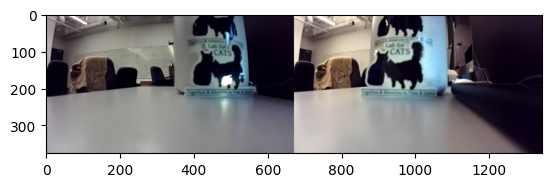

In [33]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img, gray = imload('captured_images/image_10.png')
plt.imshow(img)
plt.show()

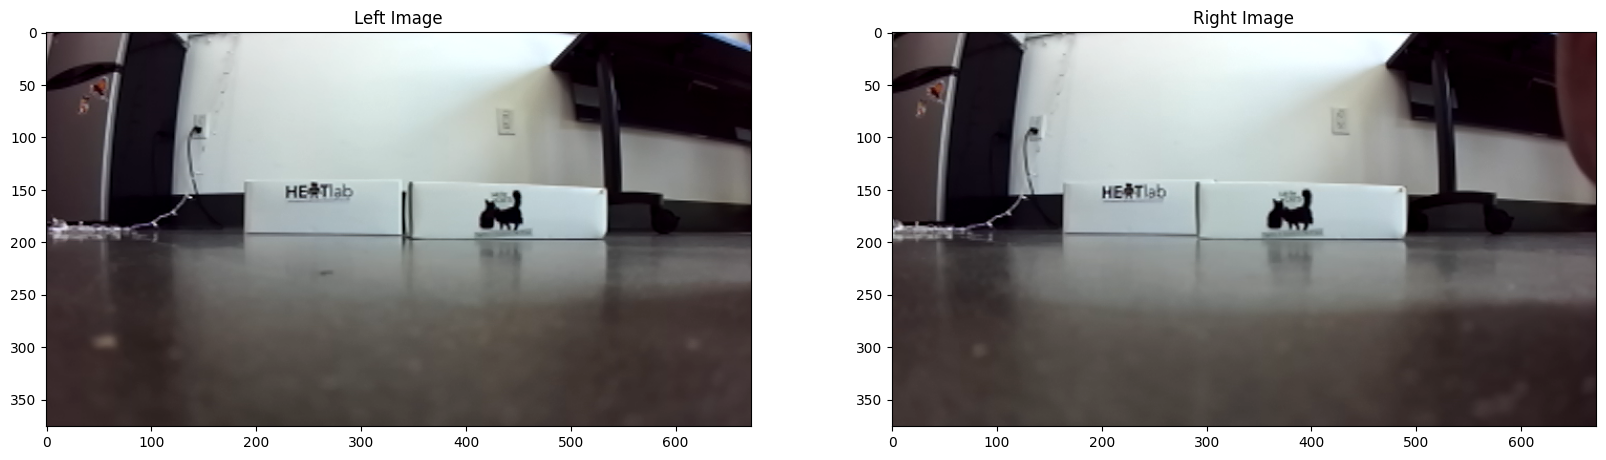

In [34]:
h, w, _ = img.shape
mid = w // 2

left_img_path = '40cm_and_100cm_left_images/left_img_5.png'
right_img_path = '40cm_and_100cm_right_images/right_img_5.png'
left_img, left_img_gray = imload(left_img_path)
right_img, right_img_gray = imload(right_img_path)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(left_img)
axs[0].set_title("Left Image")
# axs[0].axis('off')

axs[1].imshow(right_img)
axs[1].set_title("Right Image")
# axs[1].axis('off')

plt.show()

In [35]:
# We make the images grey scale to decrease computation time. Note that this will lower accuracy as our algorithm will have less information to use when matching
left_img = cv2.cvtColor(left_img, cv2.COLOR_RGB2GRAY)
right_img = cv2.cvtColor(right_img, cv2.COLOR_RGB2GRAY)
left_img = left_img.reshape(left_img.shape[0], left_img.shape[1], 1)
left_img = right_img.reshape(right_img.shape[0], right_img.shape[1], 1)
print(left_img.shape)

(376, 672, 1)


Now that we got the images separated, we want to want to perform some stereo matching. But hold your horses. First we have to make sure they are rectified so that we can use scanlines to easily find matching pixels. We must also make sure the color distribution is similar between the two. lastly, we must find the focal length of the camera so we can compute actual depth values. 

#### Camera Calibration
Below, we are going to calibrate our camera so that we can ensure our images are rectified and find the focal length of our camera.

If we want a great explanatory resource on how camera calibration works, watch the first 4 videos in this playlist:

https://www.youtube.com/playlist?list=PL2zRqk16wsdoCCLpou-dGo7QQNks1Ppzo.

In [36]:
# Use this: https://medium.com/@gupsekobas/zed-camera-calibration-and-3d-stereo-depth-estimation-2f5eacb1a83e

# This has code for getting the projection matrix from image coordinates mapped with their real world coordinates

#### First, we have to correct the picture of radial distortion

https://journal.hep.com.cn/foe/EN/10.1007/s12200-015-0453-7

https://docs.opencv.org/3.4/dc/dbb/tutorial_py_calibration.html


In [37]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
shape = (10, 7)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((shape[0]*shape[1],3), np.float32)
objp[:,:2] = np.mgrid[0:10,0:7].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('checkerboard_right_images/*.png')
for fname in images:
    print(fname)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, shape, None)
    print(ret)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, shape, corners2, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

world_coordinates = np.array([[25, 50, 75, 100, 125, 150, 75, 100, 125, 150, 175, 125], # x (mm)
                              [25, 50, 75, 100, 125, 150, 25, 50, 75, 100, 125, 25], # y
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]) # z 

image_coordinates = np.array([[441, 413, 385, 356, 327, 299, 385, 356, 327, 299, 272, 327],
                              [227, 199, 171, 142, 114, 88, 228, 200, 171, 143, 116, 228]])


# ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(world_coordinates, image_coordinates, gray.shape[::-1], None, None)

# Next time we have to take a bunch of pictures with the zed-m camera and then run the cv2 calibration script on it found at this link:
# https://docs.opencv.org/3.4/dc/dbb/tutorial_py_calibration.html 

checkerboard_right_images\right_img_1.png
True
checkerboard_right_images\right_img_10.png
True
checkerboard_right_images\right_img_2.png
True
checkerboard_right_images\right_img_3.png
True
checkerboard_right_images\right_img_4.png
True
checkerboard_right_images\right_img_5.png
True
checkerboard_right_images\right_img_6.png
True
checkerboard_right_images\right_img_7.png
True
checkerboard_right_images\right_img_8.png
True
checkerboard_right_images\right_img_9.png
True


In [38]:
# print(objp)
print(objpoints)
print(imgpoints)

[array([[0., 0., 0.],
       [1., 0., 0.],
       [2., 0., 0.],
       [3., 0., 0.],
       [4., 0., 0.],
       [5., 0., 0.],
       [6., 0., 0.],
       [7., 0., 0.],
       [8., 0., 0.],
       [9., 0., 0.],
       [0., 1., 0.],
       [1., 1., 0.],
       [2., 1., 0.],
       [3., 1., 0.],
       [4., 1., 0.],
       [5., 1., 0.],
       [6., 1., 0.],
       [7., 1., 0.],
       [8., 1., 0.],
       [9., 1., 0.],
       [0., 2., 0.],
       [1., 2., 0.],
       [2., 2., 0.],
       [3., 2., 0.],
       [4., 2., 0.],
       [5., 2., 0.],
       [6., 2., 0.],
       [7., 2., 0.],
       [8., 2., 0.],
       [9., 2., 0.],
       [0., 3., 0.],
       [1., 3., 0.],
       [2., 3., 0.],
       [3., 3., 0.],
       [4., 3., 0.],
       [5., 3., 0.],
       [6., 3., 0.],
       [7., 3., 0.],
       [8., 3., 0.],
       [9., 3., 0.],
       [0., 4., 0.],
       [1., 4., 0.],
       [2., 4., 0.],
       [3., 4., 0.],
       [4., 4., 0.],
       [5., 4., 0.],
       [6., 4., 0.],
       [7., 

In [39]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print(dist)

[[-3.66249547e-01  2.23503210e-01  2.81417792e-04 -1.39408325e-02
  -1.21372698e-01]]


In [40]:
img = cv2.imread('checkerboard_right_images/right_img_10.png')
h,  w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

In [41]:
# undistort
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv2.imwrite('calibresult.png', dst)

True

In [42]:
def get_function_to_undistort(camera_intrinsic_matrix, distortion_coefficients, img_height, img_width):
    alpha = 1 # if 0, we keep only the pixels that are valid, if 1, we keep all of the pixels and there will be some black
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(camera_intrinsic_matrix, distortion_coefficients, (img_width,img_height), alpha, (img_width,img_height))
    # print(newcameramtx)
    def undistort(image_to_undistort):
        return cv2.undistort(image_to_undistort, camera_intrinsic_matrix, distortion_coefficients, None, None)

    return undistort, roi
# Dist:
# [[-0.3143159  -0.02726447 -0.00077485  0.00132763  0.25596694]]
# Matrix:
# [[384.84102761   0.         333.0301586 ]
#  [  0.         386.04233785 193.57706885]
#  [  0.           0.           1.        ]]

zedm_camera_instrinsic_matrix_left = np.array([[386.13, 0., 339.015], 
                                               [0., 386.0575, 184.4645], 
                                               [0., 0., 1.]])
zedm_distortion_matrix_left = np.array([[-0.0396237, 0.0398924, -0.0334618, 0.0154927]])

zedm_camera_instrinsic_matrix_right = np.array([[386.94, 0., 344.185], 
                                               [0., 386.9425, 185.90525], 
                                               [0., 0., 1.]])
zedm_distortion_matrix_right = np.array([[-0.0401765, 0.0369663, -0.0256655, 0.00923272]])

img_height = 376
img_width = 672

undistort_func_orig, roi = get_function_to_undistort(zedm_camera_instrinsic_matrix_right, zedm_distortion_matrix_right, img_height, img_width)

# img to undistort
ten_cm_away = "10cm_awayright_images/right_img_16.png"
calib_img = "checkerboard_radial_calibration_right_images/right_img_8.png"
distorted_img = cv2.imread(calib_img)
# undistort
dst = undistort_func_orig(distorted_img)
# crop the image
x, y, w, h = roi
print(roi)
dst = dst[y:y+h, x:x+w]
cv2.imwrite('calibresult_orig.png', dst)

(16, 9, 641, 356)


True

In [43]:
def get_function_to_undistort(checkerboard_calibration_folder, file_extension, checkerboard_shape):
    """ 
    A function that creates a function to undistort images from a specific camera 
    Inputs:
    - checkerboard_calibration_folder:  the folder with all of the checkerboards ideally taken from different anlges where the checkerboard is flat
    - checkerboard_shape: the shape of the checkerboard (w, h) as a tuple
    - the file extension, ex: png, jpg
    Return:
    - A function that you can apply to all other images from this camera in order to undistort it
    """
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((checkerboard_shape[0]*checkerboard_shape[1],3), np.float32)
    objp[:,:2] = np.mgrid[0:10,0:7].T.reshape(-1,2)
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    images = glob.glob(f'{checkerboard_calibration_folder}/*.{file_extension}')
    img_shape = (0,0)
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_shape = gray.shape
        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, checkerboard_shape, None)
        # If found, add object points, image points (after refining them)
        if ret == True:
            print("Checkerboard Found")
            objpoints.append(objp)
            corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
            imgpoints.append(corners2)
            # Draw and display the corners
            cv2.drawChessboardCorners(img, checkerboard_shape, corners2, ret)
            cv2.imshow('img', img)
            cv2.waitKey(500)

    cv2.destroyAllWindows()

    # Must use the flag cv2.CALIB_RATIONAL_MODEL so that the distortion parameters are correctly calculated (lets you use k4 - k6)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None, flags=cv2.CALIB_RATIONAL_MODEL)

    h = img_shape[0]
    w = img_shape[1]

    

    alpha = 1 # if 0, we keep only the pixels that are valid, if 1, we keep all of the pixels and there will be some black
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), alpha, (w,h))
    
    # print(h)
    # print(w)
    # print("Dist:")
    # print(dist)
    # print("Matrix:")
    # print(mtx)

    def undistort(image_to_undistort):
        return cv2.undistort(image_to_undistort, mtx, dist, None, newcameramtx)

    return undistort, mtx, roi

undistort_func_left, calib_matrix_left, roi_left = get_function_to_undistort("checkerboard_radial_calibration_left_images", "png", (10, 7))
undistort_func_right, calib_matrix_right, roi_right = get_function_to_undistort("checkerboard_radial_calibration_right_images", "png", (10, 7))


Checkerboard Found


Checkerboard Found
Checkerboard Found
Checkerboard Found
Checkerboard Found
Checkerboard Found
Checkerboard Found
Checkerboard Found
Checkerboard Found
Checkerboard Found
Checkerboard Found
Checkerboard Found
Checkerboard Found
Checkerboard Found
Checkerboard Found
Checkerboard Found
Checkerboard Found
Checkerboard Found
Checkerboard Found
Checkerboard Found
Checkerboard Found
Checkerboard Found
Checkerboard Found
Checkerboard Found
Checkerboard Found
Checkerboard Found
Checkerboard Found
Checkerboard Found


In [44]:
f_x_left = calib_matrix_left[0, 0]
f_x_right = calib_matrix_right[0, 0]


In [45]:
# img to undistort
ten_forty_cm_away_left = "40cm_and_100cm_left_images/left_img_5.png"
ten_forty_cm_away_right = "40cm_and_100cm_right_images/right_img_5.png"
distorted_img_left = cv2.imread(ten_forty_cm_away_left)
distorted_img_right = cv2.imread(ten_forty_cm_away_right)
# undistort
dst_left = undistort_func_right(distorted_img_left)
dst_right = undistort_func_right(distorted_img_right)
# # crop the image
# x_left, y_left, w_left, h_left = roi_left
# print(roi_left)
# dst_left = dst_left[y:y+h, x:x+w]
# x_right, y_right, w_right, h_right = roi_right
# print(roi_right)
# dst_right = dst_right[y:y+h, x:x+w]
cv2.imwrite('calibresult_left.png', dst_left)
cv2.imwrite('calibresult_right.png', dst_right)

# After applying this function, note how it cuts too much of the image, this is discussed here:
# https://stackoverflow.com/questions/48990136/opencv-undistorts-only-a-central-part-of-fisheye-image 

True

In [46]:
# First, we are going to need to match image coordinates to real world coordinates

# Python code: https://github.com/polygon-software/python-visual-odometry/blob/master/Chapter%204%20-%20Camera%20Calibration.ipynb 

# Using 
world_coordinates = np.array([[25, 50, 75, 100, 125, 150, 75, 100, 125, 150, 175, 125], # x (mm)
                              [25, 50, 75, 100, 125, 150, 25, 50, 75, 100, 125, 25], # y
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]) # z 

image_coordinates = np.array([[441, 413, 385, 356, 327, 299, 385, 356, 327, 299, 272, 327],
                              [227, 199, 171, 142, 114, 88, 228, 200, 171, 143, 116, 228]])

p = np.zeros((12, 1))

print(image_coordinates.shape)

(2, 12)


![A matrix](Amatrix.png)
![P Solving](SolveForP.png)

In [47]:
# Now that we have this correspondence, we can solve the system of equations noted in this video at 2:20-4:20
# https://www.youtube.com/watch?v=GUbWsXU1mac&list=PL2zRqk16wsdoCCLpou-dGo7QQNks1Ppzo&index=3&t=173s 


def get_projection_matrix (image_coordinates, world_coordinates):
    # We must put our image coordinates into a matrix A
    A = np.zeros((2*p.shape[0], p.shape[0]))

    # Now we must populate A with the proper values
    for i in range(A.shape[0]):
        coord_idx = i // 2
        mult = 0
        if i % 2 == 0:
            A[i, 0] = world_coordinates[0, coord_idx] # Row 0 corresponds to the x coordinate
            A[i, 1] = world_coordinates[1, coord_idx] # Row 1 corresponds to the y coordinate
            A[i, 2] = world_coordinates[2, coord_idx] # Row 2 corresponds to the z coordinate
            A[i, 3] = 1
            mult = image_coordinates[0, coord_idx] # Row 0 cooresponds to the u coordinate 
        else:
            A[i, 4] = world_coordinates[0, coord_idx] # Row 0 corresponds to the x coordinate 
            A[i, 5] = world_coordinates[1, coord_idx] # Row 1 corresponds to the y coordinate
            A[i, 6] = world_coordinates[2, coord_idx] # Row 2 corresponds to the z coordinate
            A[i, 7] = 1
            mult = image_coordinates[1, coord_idx] # Row 0 cooresponds to the u coordinate 
        
        A[i, 8] = -mult*world_coordinates[0, coord_idx]
        A[i, 9] = -mult*world_coordinates[1, coord_idx]
        A[i, 10] = -mult*world_coordinates[2, coord_idx]
        A[i, 11] = -mult

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(np.matmul(A.T, A))

    min_eigen_index = np.argmin(eigenvalues[eigenvalues!= 0])
    # print(min_eigen_index)
    # print(eigenvectors)
    min_eigen_vector = eigenvectors[:,min_eigen_index]
    projection_matrix = min_eigen_vector.reshape(3, 4)

    return projection_matrix

projection_matrix = get_projection_matrix(image_coordinates, world_coordinates)

column_to_delete = 3
left_side_projection_matrix = np.delete(projection_matrix, column_to_delete, axis=1)
print(left_side_projection_matrix)
# We then use the result found above to find p

# Note that the last column is all zeroes because the z-coordinate is all zeroes in world coordinates

        

[[ 2.10611305e-03 -6.50606410e-05  0.00000000e+00]
 [-4.54617850e-05  2.11598710e-03  0.00000000e+00]
 [-1.13776241e-07 -1.95022326e-07  0.00000000e+00]]


In [48]:
def get_intrinsic_and_extrinsic(projection_matrix):
    extrinsic, intrinsic = np.linalg.qr(projection_matrix, 'complete')
    # The columns of the exteinsic matrix are orthnormal
    return intrinsic, extrinsic

intrinsic, exterinsic = get_intrinsic_and_extrinsic(left_side_projection_matrix)
print(intrinsic)
print(exterinsic)


[[-0.0021066   0.00011071  0.        ]
 [ 0.         -0.00211409  0.        ]
 [ 0.          0.          0.        ]]
[[-9.99767110e-01 -2.15806015e-02  5.60485691e-05]
 [ 2.15806067e-02 -9.99767107e-01  9.38894578e-05]
 [ 5.40093248e-05  9.50771540e-05  9.99999994e-01]]


In [49]:
# Now that we have the projection matrix, we can find the intrinsic and extrinsic camera parameters 


#### Histogram Equilization
To make sure the color distribution is similar between images, we are going to perform histogram equilization 

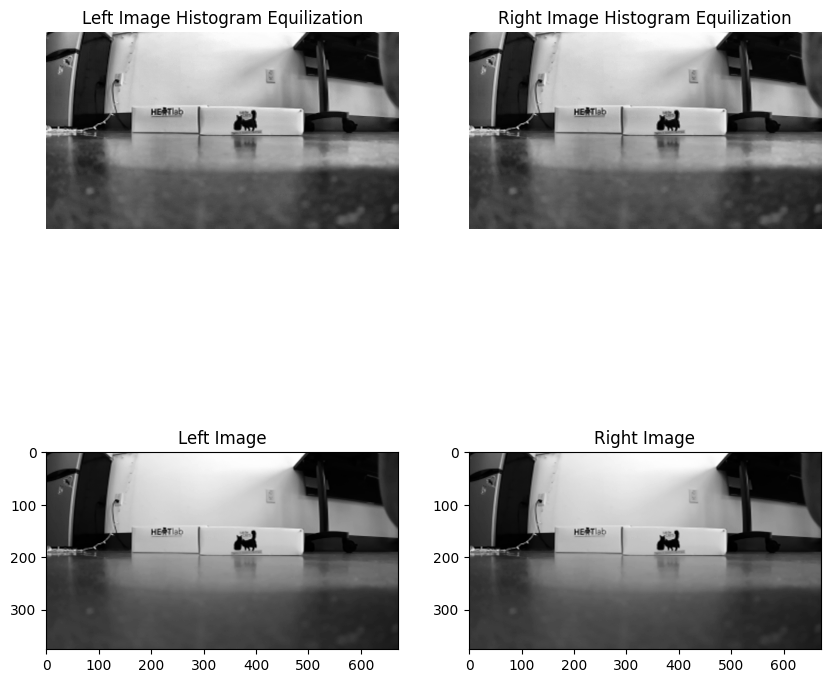

In [50]:
# We per form histogram equalization on the images to make them sharper
# clahe stands for contrast limited adaptive histogram equalization
# sadly, histogram equalization only works with gray scale images
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
left_img_histEq = clahe.apply(left_img)
right_img_histEq = clahe.apply(right_img)

# Now lets look at the before and after of histogram equilization
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(left_img_histEq, cmap="gray")
axs[0, 0].set_title("Left Image Histogram Equilization")
axs[0, 0].axis("off")
axs[0, 1].imshow(right_img_histEq, cmap="gray")
axs[0, 1].set_title("Right Image Histogram Equilization")
axs[0, 1].axis("off")
axs[1, 0].imshow(left_img, cmap="gray")
axs[1, 0].set_title("Left Image")
axs[1, 1].imshow(right_img, cmap="gray")
axs[1, 1].set_title("Right Image")

plt.show()

In [51]:
left_img = left_img_histEq
right_img = right_img_histEq

#### Disparity Calculation

We have are now at a point where our images are set up such that we can look for dense correspondences between pixels. First, we will show you a sparse correspondence to motivate how much more difficult it is to get an accurate dense correspondence. We will then go into two algorithms to get a dense correspondence: a local algorithm and a cross-scale algorithms

#### Below shows a sparse correspondence algorithm ####


Found 281 matches.


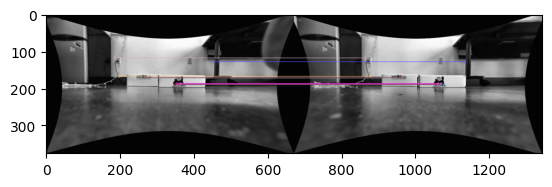

In [52]:
# Get left and right image
useTsukuba = False
if useTsukuba:
    left_img_path = "tsukuba_images/tsukuba_l.png" # "10cm_awayleft_images/left_img_10.png"
    right_img_path = "tsukuba_images/tsukuba_r.png" # "10cm_awayright_images/right_img_10.png"
    img_left = cv2.imread(left_img_path)
    img_right = cv2.imread(right_img_path)
    img_left = np.delete(img_left, [1, 2], 2)
    img_right = np.delete(img_right, [1, 2], 2)
    img_left_gray = img_left
    img_right_gray = img_right
else:
    img_left, img_left_gray = imload(left_img_path)
    img_right, img_right_gray = imload(right_img_path)

    img_left_gray = undistort_func_right(img_left_gray)
    img_right_gray = undistort_func_right(img_right_gray)

# We per form histogram equalization on the images to make them sharper
# clahe stands for contrast limited adaptive histogram equalization
# sadly, histogram equalization only works with gray scale images
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_left_histEq = clahe.apply(img_left_gray)
img_right_histEq = clahe.apply(img_right_gray)

# We need to find the correspondences
descriptor = cv2.ORB_create()

# keypoints are the actual points in the image
# kps ar ethe actual points in the image
# featuresL is an embedding that describes those points
kpsL, featsL = descriptor.detectAndCompute(img_left_gray, None)
kpsR, featsR = descriptor.detectAndCompute(img_right_gray, None)

# NOw create the matcher and find matches
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches = matcher.match(featsR,featsL)

print('Found ' + str(len(matches)) + ' matches.')

# Next we draw the matches
# Sort matches using lambda notation - lifted straight from Silva's code, because I can never remember this syntax
sorted_matches = sorted(matches, key = lambda x:x.distance)

# The number of matches to keep
# Note that when finding the homography, we probably want a good number (~100 or so)
# For visualization, we can always drop this way down to really get a clear look at what is being matched
num_keep = 10 

matched_img = cv2.drawMatches(img_right_histEq, kpsR, img_left_histEq, kpsL, sorted_matches[:num_keep], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(matched_img)

# Now we just need some constants b, and f_x where b is the distance between cameras and f_x
# is a camera intrinsic



Let's find the pixel positions of one pair of these matches:

In [53]:
best_match = sorted_matches[0]
# Get the pixel coordinates of the keypoints in the left and right images for the best match
pixel_coord_left = kpsL[best_match.trainIdx].pt
pixel_coord_right = kpsR[best_match.queryIdx].pt

print(pixel_coord_left)
print(pixel_coord_right)

(393.1200256347656, 187.20001220703125)
(358.5600280761719, 187.20001220703125)


Notice how these pixel positions only differ in their x values and not their y values. We should expect this since the images taken are stereo images and so are on the same y scanline. The difference's between the x values is called the disparity and it is inversely proportional to the distance the point is to the camera. The farther the distance is, the smaller the disparity between the two corresponding points in each of the stereo images. Therefore, disparity is inversley proportion to depth. The lower the disparity is, the higher the depth is. If you want a more indepth guide to stereo depth estimation with great visuals, then watch this video: https://www.youtube.com/watch?v=hUVyDabn1Mg&t=600s.

But we want to find depth throughout the whole image, not just a sparse collection of pairs. We choose the left image to find depth in. We will try to match every point in the left image with a point in the right image. Then we subtract the x-coordinates of the matched pair to find the disparity and from disparity we can get depth. 

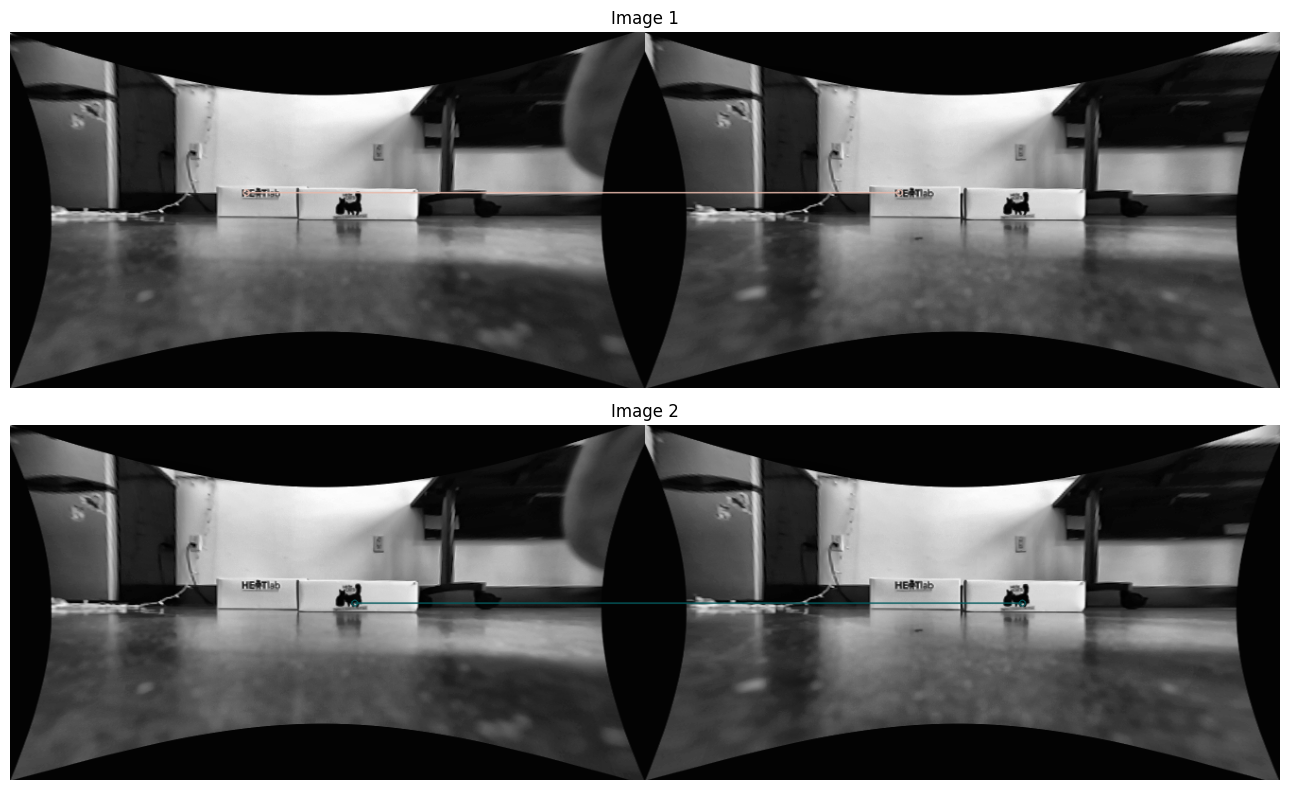

In [54]:
# Now we get a correspondence from the sticker because that is 10cm away
# The start to end range gives us a match that is on the object 10cm away
first_match_start = 27
first_match_end = 28

second_match_start=1
second_match_end=2
matched_img_100cm = cv2.drawMatches(img_right_histEq, kpsR, img_left_histEq, kpsL, sorted_matches[first_match_start:first_match_end], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# plt.imshow(matched_img_cat)
# plt.axis('off')

matched_img_40cm = cv2.drawMatches(img_right_histEq, kpsR, img_left_histEq, kpsL, sorted_matches[second_match_start:second_match_end], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


# plt.imshow(matched_img_shirt)
# plt.axis('off')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

# Plot the first image on the first subplot
axes[0].imshow(matched_img_100cm)
axes[0].set_title('Image 1')
axes[0].axis('off')

# Plot the second image on the second subplot
axes[1].imshow(matched_img_40cm)
axes[1].set_title('Image 2')
axes[1].axis('off')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

In [56]:
# Now we will compute the depth using the camera intrinsics for the match above
b = 63.1542 # In millimeters
# f_x = (386.94+386.13)/2 # getting the average between the two cameras for vga
f_x = f_x_left #(773.88+772.26)/2
mm_to_pixel_constant = 0.113874335116
print(f_x)
first_match = sorted_matches[first_match_start]
first_match_disparity = first_match.distance
print(f"70cm_disparity: {first_match_disparity}")
depth_70 = b*f_x*mm_to_pixel_constant/first_match_disparity 
division = 10
depth_70 /= division # to make it in cm
print(f"Depth of match above: {depth_70} cm")

second_match = sorted_matches[second_match_start]
second_match_disparity = second_match.distance
print(f"40cm_disparity: {second_match_disparity}")
depth_40 = b*f_x*mm_to_pixel_constant/second_match_disparity 
depth_40 /= division # to make it in cm
print(f"Depth of match above: {depth_40} cm")

# UofT slides: https://www.cs.toronto.edu/~fidler/slides/2015/CSC420/lecture12_hres.pdf 


400.0822940958778
70cm_disparity: 9.0
Depth of match above: 31.969431595927013 cm
40cm_disparity: 4.0
Depth of match above: 71.93122109083578 cm


#### Now we will show a dense correspondence algorithm

As said, we want to match every point in the left image with a point in the right image. We must do this for every pixel. The algorithm we will use is a template matching algorithm. Basically, for each pixel in the left image, we get a window around it. We then compare this window to all windows in the right image on the scanline. The pixel that has a window that matches becomes a pair to the pixel in the left image. We then use this pair to compute the disparity and then the depth.


In [11]:
# We will use sum of squared distance's (SSD) as our cost calculation. 
def cost_function(array1, array2):
    # Made it like this so you can easily switch out cost functions
    return SSD_cost(array1, array2)

def SSD_cost(array1, array2):
    """
    Description:

    Paramters:
        array1, numpy array
        array2, numpy array
    Returns:

    """
    return np.sum((array1-array2)**2, axis=None)

"""
Now lets put some tests to make sure it works
- If you want to make your own cost_function, alter the one above and make your test case below
"""
array1 = np.array([[[1, 2, 3]], [[1, 2, 3]]])
array2 = np.array([[[3, 4, 5]], [[3, 4, 5]]])
output = 24

# Do assertion
assert np.isclose(SSD_cost(array1, array2), output)

In [12]:
# Now  for each pixel in the left image we will go through 
# each pixel in the right image (only in the row of the left pixel)
# and compute the cost. We find the minimum most cost and store the
# the location for that 
def get_disparity(img_left, img_right, cost_function=cost_function, kernel_width = 15, kernel_height = 15, max_offset = 80):
    """
    Description: uses local algorithms to get the disparity

    Parameters:
        - img_left, grey scale image
        - img_right, grey scale image
        - cost_function, cost function to use for matching cost computation and aggregation
        - kernel_size, should be odd
    """
    if len(img_left.shape) == 2:
        h_l, w_l = img_left.shape
        h_r, w_r = img_right.shape
    elif len(img_left.shape) == 3:
        h_l, w_l, d_l = img_left.shape
        h_r, w_r, d_r = img_right.shape
    else:
        return None, None

    if (w_r != w_l or h_l != h_r):
        return None, None
    # the depth (last value) is w_l because for each pixel in a row we go through all the columns
    # and find a cost for that
    cost_matrix = np.zeros((h_l, w_l, w_l))
    disparity_matrix = np.zeros((h_l, w_l, w_l))
    best_disparity_matrix = np.zeros((h_l, w_l))
    # Go through each pixel in img_left
    for r_l in range(h_l):
        for c_l in range(w_l):
            # The math for upper is done as if the origin is at the top left, so upper
            # is considering the bound at 0 to be the upper bound
            upper_reference_window_bound = max(0, r_l - kernel_height//2)
            lower_reference_window_bound = min(h_l, r_l + kernel_height//2)
            left_reference_window_bound = max(0, c_l - kernel_width//2)
            left_difference = abs(left_reference_window_bound - c_l)
            right_reference_window_bound = min(w_l-1, c_l + kernel_width//2)
            right_difference = abs(right_reference_window_bound-c_l)
            if len(img_left.shape) == 2:
                reference_window = img_left[upper_reference_window_bound : lower_reference_window_bound,left_reference_window_bound : right_reference_window_bound+1]
            else:
                reference_window = img_left[upper_reference_window_bound : lower_reference_window_bound,left_reference_window_bound : right_reference_window_bound+1,:]

            # Now we go through each column in img_right for our row
            # We can go from c_l to w_r because we expect everything in the right image
            # to be on the right of things in the left image
            min_cost = float('inf')
            best_disparity = -1
            for c_r in range(min(c_l+max_offset, w_l)):
                # We get the window we want to compare
                left_comparison_window_bound = c_r - left_difference
                right_comparison_window_bound = c_r + right_difference
                if left_comparison_window_bound < 0 or right_comparison_window_bound >= w_r:
                     cost_matrix[r_l, c_l, c_r] = float('inf')
                     disparity_matrix[r_l, c_l, c_r] = float('inf')
                     continue
                # Window is at a different row since it is 1xkernel_size
                if len(img_left.shape) == 2:
                    comparison_window = img_right[upper_reference_window_bound:lower_reference_window_bound,left_comparison_window_bound:right_comparison_window_bound+1]
                else:
                    comparison_window = img_right[upper_reference_window_bound:lower_reference_window_bound,left_comparison_window_bound:right_comparison_window_bound+1,:]
                # Now that we have both the reference_window and comparison_window, we compute cost
                cost = cost_function(reference_window, comparison_window)
                # Now calculate the disparity as if we calculated it here
                disparity = abs(c_l-c_r) # I use math.abs, but all of these should be the same sign
                cost_matrix[r_l, c_l, c_r] = cost
                disparity_matrix[r_l, c_l, c_r] = disparity
                if cost < min_cost:
                    min_cost = cost
                    best_disparity = disparity

            best_disparity_matrix[r_l, c_l] = best_disparity
            

    return cost_matrix, best_disparity_matrix

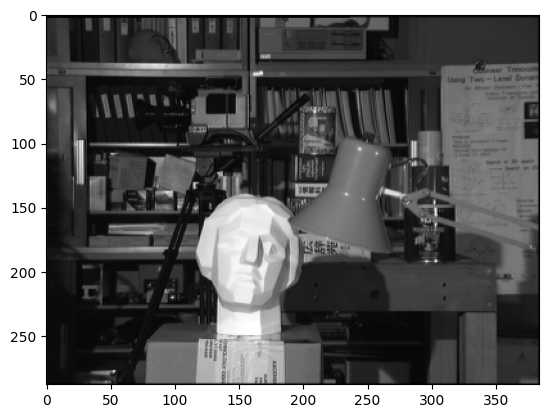

In [13]:
plt.imshow(img_left_gray, cmap="gray")
plt.show()

In [103]:
"""So, going back to how stereo matching algorithms work, the above function does:
1. matching cost computation: our cost function subtracting individual pixel values and squaring
2. cost (support) aggregation: our cost function aggregating these costs in a window
3. disparity computation: simply finding the disparity based on the minimum cost"""

# because it would take forever to do the whole image, we are going to crop both left and right images
top, left = 0, 0 # 100, 100
bottom, right = img_left.shape[0], img_left.shape[1]# 250, 250
img_left_gray_crop = img_left_histEq[top:bottom,left:right]
img_right_gray_crop = img_right_histEq[top:bottom,left:right]


cost_matrix, best_disparity_img = get_disparity(img_left_gray_crop, img_right_gray_crop)

In [ ]:
# The below code uses the full rgb image, it takes longer to compute which is why it is commented out
# img_left_crop = img_left_histEq[top:bottom,left:right]
# img_right_crop = img_right_histEq[top:bottom,left:right]
# cost_matrix_color, best_disparity_img_color = get_disparity(img_left_crop, img_right_crop, kernel_width=21, kernel_height=21)

In [104]:
# Now we get the depth 
# Set dummy variabels for b and f_x
b = 63.1542 # In centimeters
f_x = (386.94+386.13)/2 # getting the average between the two cameras
best_depth_img = (b*f_x)/best_disparity_img

C:\Users\Joshua\AppData\Local\Temp\ipykernel_71124\1039391307.py:5: RuntimeWarning: divide by zero encountered in divide
  best_depth_img = (b*f_x)/best_disparity_img


(288, 384)
[[  6.  63.  63.  63.  63.  63.  63.  63.  63.  63.   3.   4.   5.   5.
    5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.
    5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.
    5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.
    5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.
    5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.
    5.   5.   5.   5.   2.   5.   5.   5.   5.   5.   5.   5.   5.   5.
    5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.
    5.   5.   5.   5.   5.   5.   5.   5.   5.   6.   9.   6.   6.   6.
    6.   6.   6.   5.   5.   5.   5.   5.   5.  20.   5.   5.  20.  20.
    5.   5.   5.  20.  20.  32.  32.  32.   5.   5.   5.   5.   5.   5.
    5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.
    5.   5.   5.   5.   5.   5.   4.   5.   5.   5.   5.   5.   5.   5.
    5.   5.   5.   5.   5.   5.   5.   5.   5.   5.  

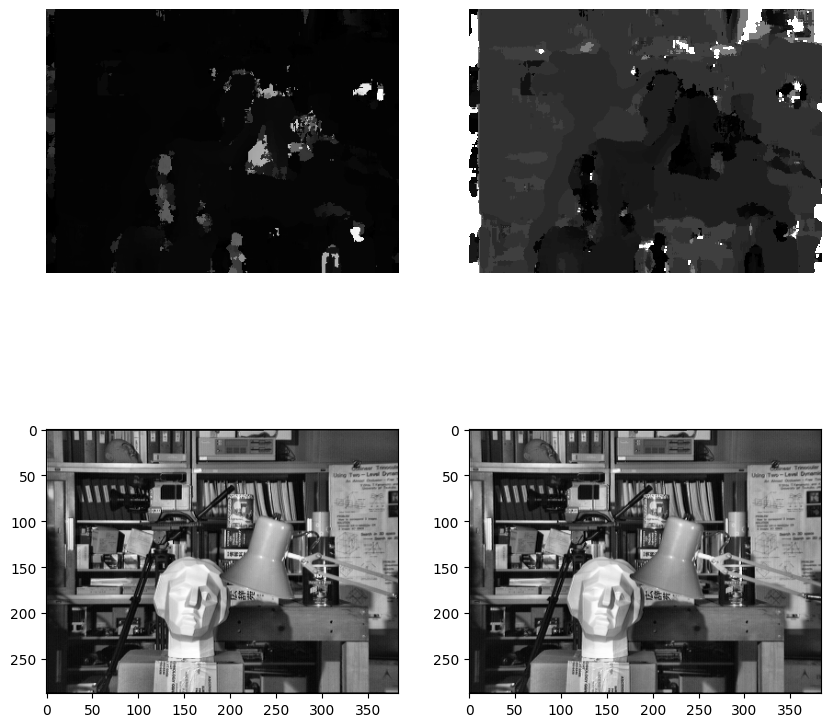

In [105]:
# Now lets show the disparity matrix as an image
print(best_disparity_img.shape)
print(best_disparity_img)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(best_disparity_img, cmap="gray")
axs[0, 0].axis("off")
axs[0, 1].imshow(best_depth_img, cmap="gray")
axs[0, 1].axis("off")
axs[1, 0].imshow(img_left_gray_crop, cmap="gray")
axs[1, 1].imshow(img_right_gray_crop, cmap="gray")

plt.show()

#### Now we will discuss the general global matching algorithm

General global stereo matching algorithm (from Szeliski): 

$$E(d) = E_{data}(d) + \lambda E_S(d)$$

We want to minimize the above function $E(d)$. In more explainable terms, the above equation defines a cost function $E(d)$ where the overall cost depends on two separate costs. First is the cost of the data points given a particular disparity: $E_{data}(d)$. You can think of this as the window based method used above, where it finds a disparity and calculates a cost for that disparity (the cost being the SSD in a window). Second is the cost of the disparities of neighboring pixels. We want to minimize this cost so that neighboring pixels have similar disparities. You may note that this explicitly tries to make the disparity map smooth, which may not be true in some cases.

We further expand each term in the equations below where $C$ is the cost function, $d$ is the disparity function, and $p$ is a monotonically increasing function. $p$ is monotonically increasing so that we can punish disparities that are have a bigger difference. 

$$E_{data}(d) = \sum_{(x,y)}C(x, y, d(x, y))$$

Let's dissect this a bit more. The above function $E_{data}(d)$ outputs a sum of the cost of each data point given a disparity function. We can think of the disparity function as the output from the local window algorithm that we implemented above. Then, that algorithm will return the disparity and we would use a cost function to obtain the cost with that disparity. 

$$E_S(d) = \sum_{(x,y)} p(d(x,y) - d(x+1, y)) + p(d(x, y) - d(x, y+1))$$

In the above equation, we compare neighboring pixel's disparity values to eachother. Note that we do not have to compare just $(x+1, y)$ and $(x, y+1)$ to $(x, y)$, we can compare anything in an informative neighborhood. Note that because $p$ is monotonically increasing, disparity values that are farther apart from eachother will have higher energy than disparity values that are closer. Since we are trying to minimize energy, we are trying to make disparities be closer to eachother. This is what encoded the explicit smoothness assumption. Lets think back to using the local window algorithm to find disparities. Minimizing the above equation would be akin to finding a window size where the disparity map is "smooth" since a smooth disparitiy map means the disparities are closer together. 

Note how computationally expensive this problem is. For each disparity function that we calculate (which could take a long time to do) we must also minimize the disparity between any two points. In essence, we most explore the disparity space and find the right dispartiy assignments to minimize a combination of the cost for the data and the cost for neighboring disparties. In the case of the local window algorithm implemented above, not only would we have to create a disparity map for a given window size (which we saw is computationally expensive), but we would have to alter the window size until we find a disparity map such that we can minimize both $E_{data}$ and $E_S(d)$. 

This motivates the need for a Semi-Global Matching algorithm that is able to get more information from the picture like a global algorithm, but uses only local information like a local algorithm. This allows it to run faster and still be pretty accurate.

#### Semi-Global Matching algorithm introduction

General Overview

Semi-global matching algorithms take information from in multiple directions near the pixel of interest in order to calculate disparity. Below we will implement an algorithm that does this. For cost computation we will use the sum of squared distances. For cost aggregation we will aggregate costs at different scales of the image. For disparity computation we will just pick the one with the smallest cost. For disparity refinement, we will smooth disparities based on horizontal and vertical sobel filters.

In [14]:
# Just for better readibility, lets define the cost function again
# We will use sum of squared distance's (SSD) as our cost calculation 
def cost_function(array1, array2):
    # Made it like this so you can easily switch out cost functions
    return SAD_cost(array1, array2)

def SSD_cost(array1, array2):
    """
    Description:

    Paramters:
        array1, numpy array
        array2, numpy array
    Returns:

    """
    return np.sum((array1-array2)**2, axis=None)


def SAD_cost(array1, array2):
    """
    Description:

    Paramters:
        array1, numpy array
        array2, numpy array
    Returns:

    """
    return np.sum(np.abs((array1-array2)), axis=None)

In [29]:
from enum import Enum

class ImageFeature(Enum):
    COLOR_IMG="color_img"
    GRAD_X_IMG="grad_x_img"
    GRAD_Y_IMG="grad_y_img"
    GRAD_XY_IMG="grad_y_img"

In [30]:
def get_img_features_at_scales(img_left, img_right, blur_kernel_size=9, grad_kernel_size=3, scale_count=4):
    """
    Description: 
        scales img_left and img_right by dividing height and width by 2 each time. The kernel usage below with opencv
        is non-destructive, so the images are the same size before and after


    Parameters:

    Return:
    """
    # We define 2 new images, one for horizontal sobel filter and one for vertical
    # If you want to use the guided filter, you have to "pip install opencv-contrib-python" before you install
    # opencv and you must also not have any other opencv packages installed. This seems very invasive, so we just
    # just use the sobel filter and gaussian_blur

    # First, we must make the image at different scales 
    # Note how we are using derivative features in order to get more information from the image.
    # Think of these as forming a feature vector for each pixel
    img_scales = range(scale_count) # So we will scale the image 4 times, at 1, 1/2, 1/4, 1/8
    scaled_img_features = {}
    img_scaled_left = img_left
    img_scaled_right = img_right
    for scale in img_scales:
        #  We don't want the first one to cut the image in half, we still want one full image 
        if scale != 0: 
            img_scaled_left = cv2.pyrDown(img_scaled_left) # This just cuts the image in half
            img_scaled_right = cv2.pyrDown(img_scaled_right) # This just cuts the image in half
        # print(f"{scale}, rows: {img_scaled_left.shape[0]} | cols: {img_scaled_left.shape[1]}")

        gaussian_blur_left = cv2.GaussianBlur(img_scaled_left, (blur_kernel_size, blur_kernel_size), 0)
        gaussian_blur_right = cv2.GaussianBlur(img_scaled_right, (blur_kernel_size, blur_kernel_size), 0)

        grad_x_left = cv2.Sobel(gaussian_blur_left, cv2.CV_64F, 1, 0, ksize = grad_kernel_size)
        cv2.convertScaleAbs(grad_x_left)
        grad_y_left = cv2.Sobel(gaussian_blur_left, cv2.CV_64F, 0, 1, ksize = grad_kernel_size)
        cv2.convertScaleAbs(grad_y_left)
        grad_xy_left = cv2.Sobel(gaussian_blur_left, cv2.CV_64F, 1, 1, ksize = grad_kernel_size)
        cv2.convertScaleAbs(grad_xy_left)
        grad_left = cv2.addWeighted(grad_x_left, 0.5, grad_y_left, 0.5, 0)
        
        grad_x_right = cv2.Sobel(gaussian_blur_right, cv2.CV_64F, 1, 0, ksize = grad_kernel_size)
        cv2.convertScaleAbs(grad_x_right)
        grad_y_right = cv2.Sobel(gaussian_blur_right, cv2.CV_64F, 0, 1, ksize = grad_kernel_size)
        cv2.convertScaleAbs(grad_y_right)
        grad_xy_right = cv2.Sobel(gaussian_blur_right, cv2.CV_64F, 1, 1, ksize = grad_kernel_size)
        cv2.convertScaleAbs(grad_xy_right)
        grad_right = cv2.addWeighted(grad_x_right, 0.5, grad_y_right, 0.5, 0)

        # # Ensures that the output image features are the same size as the input 
        # print((gaussian_blur_left.shape == img_scaled_left.shape))
        # print((grad_x_left.shape == img_scaled_left.shape))

        scaled_img_features[str(scale)] = {}

        scaled_img_features[str(scale)]["left"] = {}
        scaled_img_features[str(scale)]["left"][ImageFeature.COLOR_IMG] = gaussian_blur_left
        scaled_img_features[str(scale)]["left"][ImageFeature.GRAD_X_IMG] = grad_x_left
        # scaled_img_features[str(scale)]["left"][ImageFeature.GRAD_Y_IMG] = grad_y_left
        # scaled_img_features[str(scale)]["left"][ImageFeature.GRAD_XY_IMG] = grad_left

        scaled_img_features[str(scale)]["right"] = {}
        scaled_img_features[str(scale)]["right"][ImageFeature.COLOR_IMG] = gaussian_blur_right
        scaled_img_features[str(scale)]["right"][ImageFeature.GRAD_X_IMG] = grad_x_right
        # scaled_img_features[str(scale)]["right"][ImageFeature.GRAD_Y_IMG] = grad_y_right
        # scaled_img_features[str(scale)]["right"][ImageFeature.GRAD_XY_IMG] = grad_right
        
        # # Code for visualizing each scale
        # if scale == 0:
        #     fig, axs = plt.subplots(2, 2, figsize=(10, 10))

        #     axs[0, 0].imshow(grad_left, cmap="gray")
        #     # axs[0].axis("off")
        #     # axs[0, 1].imshow(grad_xy_left, cmap="gray")
        #     # axs[1].axis("off")
        #     # axs[1, 0].imshow(grad_x_left, cmap="gray")
        #     # # axs[1].axis("off")
        #     # axs[1, 1].imshow(grad_y_left, cmap="gray")
        #     # # axs[1].axis("off")

        #     # # print(img_scaled_left.shape)
        #     # # print(grad_left.shape)
        #     # # print(grad_xy_left.shape)
        #     # # print(gaussian_blur_left)
        #     # print(grad_left.shape)
        #     # print(grad_left)
        #     # print(grad_xy_left)
        #     plt.legend()
        #     plt.show()

    return scaled_img_features

img_left = cv2.imread("tsukuba_images/tsukuba_l.png")
img_right = cv2.imread("tsukuba_images/tsukuba_r.png")
img_left_gray = cv2.cvtColor(img_left, cv2.COLOR_RGB2GRAY)
img_right_gray = cv2.cvtColor(img_right, cv2.COLOR_RGB2GRAY)
scaled_img_features = get_img_features_at_scales(img_left_gray, img_right_gray)

In [31]:
""" 

"""
def calculate_pixel_pair_cost(left_pixel, right_pixel, img_left, img_right, kernel_height, kernel_width, cost_function=cost_function):
    """
    Description: 
    This function takes in a pixel in the left image and a pixel in the right image and the kernel size parameters and computes the cost 
    between those two pixels given the kernel size parameters 
        Note that the reference_window refers to the window size in the left_img while the comparison_window is the window in the right image
    Params:

    Return
    """
    if len(img_left.shape) == 2:
        h_l, w_l = img_left.shape
        h_r, w_r = img_right.shape
    elif len(img_left.shape) == 3:
        h_l, w_l, d_l = img_left.shape
        h_r, w_r, d_r = img_right.shape
    else:
        ValueError("Image shape is not length 2 or length 3")
        return


    left_pixel_row = left_pixel[0]
    left_pixel_col = left_pixel[1]

    right_pixel_row = right_pixel[0]
    right_pixel_col = right_pixel[1]

    upper_reference_window_bound = max(0, left_pixel_row - kernel_height//2)
    lower_reference_window_bound = min(h_l-1, left_pixel_row + kernel_height//2)
    left_reference_window_bound = max(0, left_pixel_col - kernel_width//2)
    left_difference = abs(left_reference_window_bound - left_pixel_col)
    right_reference_window_bound = min(w_l-1, left_pixel_col + kernel_width//2)
    right_difference = abs(right_reference_window_bound-left_pixel_col)

    # plt.title(f"Img Params: {img_left.shape} for {left_pixel}")
    # plt.imshow(img_left, cmap="gray")
    # plt.scatter(left_pixel_row, left_pixel_col, marker="x", color="red", s=200)
    # plt.show()

    if len(img_left.shape) == 2:
        reference_window = img_left[upper_reference_window_bound : lower_reference_window_bound+1,left_reference_window_bound : right_reference_window_bound+1]
    else:
        reference_window = img_left[upper_reference_window_bound : lower_reference_window_bound+1,left_reference_window_bound : right_reference_window_bound+1,:]
        
    left_comparison_window_bound = right_pixel_col - left_difference
    right_comparison_window_bound = right_pixel_col + right_difference
    if left_comparison_window_bound < 0 or right_comparison_window_bound >= w_r:
        return float("inf")
    # Window is at a different row since it is 1xkernel_size
    if len(img_left.shape) == 2:
        comparison_window = img_right[upper_reference_window_bound:lower_reference_window_bound+1,left_comparison_window_bound:right_comparison_window_bound+1]
    else:
        comparison_window = img_right[upper_reference_window_bound:lower_reference_window_bound+1,left_comparison_window_bound:right_comparison_window_bound+1,:]
    
    return cost_function(reference_window, comparison_window)

# # Testing out exclusivity of bounds 
# test1 = img_left[0:10,0:10]
# plt.imshow(test1)

# Simple test to make sure it works
pixel1 = (150, 150)
pixel2 = (150, 150)
cost = calculate_pixel_pair_cost(pixel1, pixel2, img_left, img_left, 5, 5)
assert cost == 0

In [32]:
"""
Goes through each pixel in the left and right images and calculates the cost based on calculate_pixel_pair_cost 
"""
def calculate_pixel_pair_cost_at_all_scales(left_pixel, right_pixel, img_features_mult_scales, kernel_height, kernel_width, weighting_filter=None, _lambda=1.0):
    total_cost = 0

    scale_costs = []

    # This function calculates the cost 
    left_pixel_at_scale = np.copy(left_pixel)
    right_pixel_at_scale = np.copy(right_pixel)
    for scale in img_features_mult_scales:
        # rint("Scale:", scale)
        scale_cost = 0
        img_dict = img_features_mult_scales[str(scale)]

        img_left_dict = img_dict["left"]
        img_right_dict = img_dict["right"]

        img_feature_names = list(img_left_dict.keys())

        for feature in img_feature_names:
            if feature not in img_right_dict:
                continue
            else:
                left_feature_img = img_left_dict[feature]
                right_feature_img = img_right_dict[feature]

                cost = calculate_pixel_pair_cost(left_pixel_at_scale, right_pixel_at_scale, left_feature_img, right_feature_img, kernel_height, kernel_width, cost_function=cost_function)
                # print("Cost: ", cost)
                scale_cost += cost 
                
        left_pixel_at_scale = left_pixel_at_scale // 2
        right_pixel_at_scale = right_pixel_at_scale // 2

        scale_costs.append(scale_cost)

    # This function acts as a regularization parameter for punishing majorly different costs 
    regularization_cost = 0
    for i in range (1, len(scale_costs)):
        current_scale = scale_costs[i]
        previous_scale = scale_costs[i-1]

        if (previous_scale == float("inf") and current_scale == float("inf")):
            regularization_cost = float("inf")
        else:
            regularization_cost += abs(current_scale-previous_scale)
        
        if regularization_cost == float("inf"):
            break
    
    regularization_cost *= _lambda

    total_cost += sum(scale_costs)
    total_cost += regularization_cost
    # print("all scale cost: ", sum(scale_costs))
    # print("regularization cost: ", regularization_cost)
    # NaNs are coming from inf - inf
    return total_cost

# Simple test to make sure it works
pixel1 = (150, 150)
pixel2 = (150, 150)
img_features_mult_scales = get_img_features_at_scales(img_left, img_left)
cost = calculate_pixel_pair_cost_at_all_scales(pixel1, pixel2, img_features_mult_scales, 5, 5)
assert cost == 0

In [43]:
# Now, lets implement a global stereo matching algorithm, we will implement a very bare bones method
# Now  for each pixel in the left image we will go through 
# each pixel in the right image (only in the row of the left pixel)
# and compute the cost. We find the minimum most cost and store the
# the location for that
def get_disparity_SGM(img_left, img_right, cost_function=cost_function, kernel_width = 15, kernel_height = 15, max_offset = 150, scale_count = 4,_lambda=1.0):
    """
    Description: uses local algorithms to get the disparity

    Parameters:
        - img_left, grey scale image
        - img_right, grey scale image
        - cost_function, cost function to use for matching cost computation and aggregation
        - kernel_size, should be odd
    """
    if len(img_left.shape) == 2:
        h_l, w_l = img_left.shape
        h_r, w_r = img_right.shape
    elif len(img_left.shape) == 3:
        h_l, w_l, d_l = img_left.shape
        h_r, w_r, d_r = img_right.shape
    else:
        return None, None

    if (w_r != w_l or h_l != h_r):
        return None, None
    scaled_img_features = get_img_features_at_scales(img_left, img_right, scale_count=scale_count)
    
    cost_matrix = np.zeros((h_l, w_l, w_l))
    disparity_matrix = np.zeros((h_l, w_l, w_l))
    best_disparity_matrix = np.zeros((h_l, w_l))
    
    for r_l in tqdm(range(h_l)):
        for c_l in range(w_l):
            min_cost = float('inf')
            best_disparity = -1
            for c_r in range(min(c_l+max_offset, w_l)):
                # Now we want to compare two pixels using the different scales above 
                left_pixel = (r_l, c_l)
                right_pixel = (r_l,c_r)
                # print(f"c_l: {c_l} | c_r: {c_r}")
                cost = calculate_pixel_pair_cost_at_all_scales(left_pixel, right_pixel, scaled_img_features, kernel_height, kernel_width, _lambda=_lambda)
                # print("cost: ", cost)
                disparity = abs(c_l-c_r) # I use math.abs, but all of these should be the same sign
                cost_matrix[r_l, c_l, c_r] = cost
                disparity_matrix[r_l, c_l, c_r] = disparity
                if cost < min_cost:
                    # print("New min cost: ", cost)
                    # print("New disparity: ", disparity)
                    min_cost = cost
                    best_disparity = disparity

            best_disparity_matrix[r_l, c_l] = best_disparity

    return cost_matrix, best_disparity_matrix



img_left = cv2.imread("tsukuba_images/tsukuba_l.png")
img_right = cv2.imread("tsukuba_images/tsukuba_r.png")

img_left_gray = cv2.cvtColor(img_left, cv2.COLOR_RGB2GRAY)
img_right_gray = cv2.cvtColor(img_right, cv2.COLOR_RGB2GRAY)

top, left = 0, 0 # 125, 125 # 0, 0
bottom, right = img_left.shape[0], img_left.shape[1] # 175, 200 # img_left.shape[0], img_left.shape[1]
img_left_gray_crop = img_left_gray[top:bottom,left:right]
img_right_gray_crop = img_right_gray[top:bottom,left:right]

cost_matrix, best_disparity_matrix = get_disparity_SGM(img_left_gray_crop, img_right_gray_crop, scale_count=1, _lambda=1.0)

100%|██████████| 288/288 [18:14<00:00,  3.80s/it]


In [46]:
# print(cost_matrix)
np.set_printoptions(threshold=np.inf)
print(best_disparity_matrix)

[[ 61.  61.  60.  60.  59.  47.  47.  47.  46.  45.  44.   4.   5.   5.
    5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.
    5.   5.   5.   5.   5.   5.   5.   5.   5.  18.  18.  18.  18.  19.
   19.  19.  19.  19.  19.  19.  78.  78.  78.  38.  38.  38.  38.  38.
   38.  38.  38.   5.   5.   5.   5.  47.  48.  48.  49.  49.  50.  50.
   50.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.
    5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.
    5.   5.   5.  26.  24.  96.  96.   6.   6.   6.   6.   6.  33.  33.
   33.  61.  60.  60.  60.  60.  60.  60.  60.   9.   9.   9.   9.   9.
    9.  73.  74.  74.  74.  74. 120. 115. 120. 120. 120. 120. 120. 131.
  131. 130.   5.  88.  88.  88.  88.  88.  88.  88. 135. 135. 135. 135.
  135.  99.   5.   5.  97.  12.  12.  12.  12.  12.  12.   5.   5.  97.
   97.  97.  98.  98.  98.  98.  98.  98.  97. 166. 166. 166. 119. 119.
  119. 119. 119. 119. 119. 119. 118. 118. 119.   5.   5.   5.   

C:\Users\Joshua\AppData\Local\Temp\ipykernel_26468\1093438457.py:5: RuntimeWarning: divide by zero encountered in divide
  best_depth_img = (b*f_x)/best_disparity_img
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


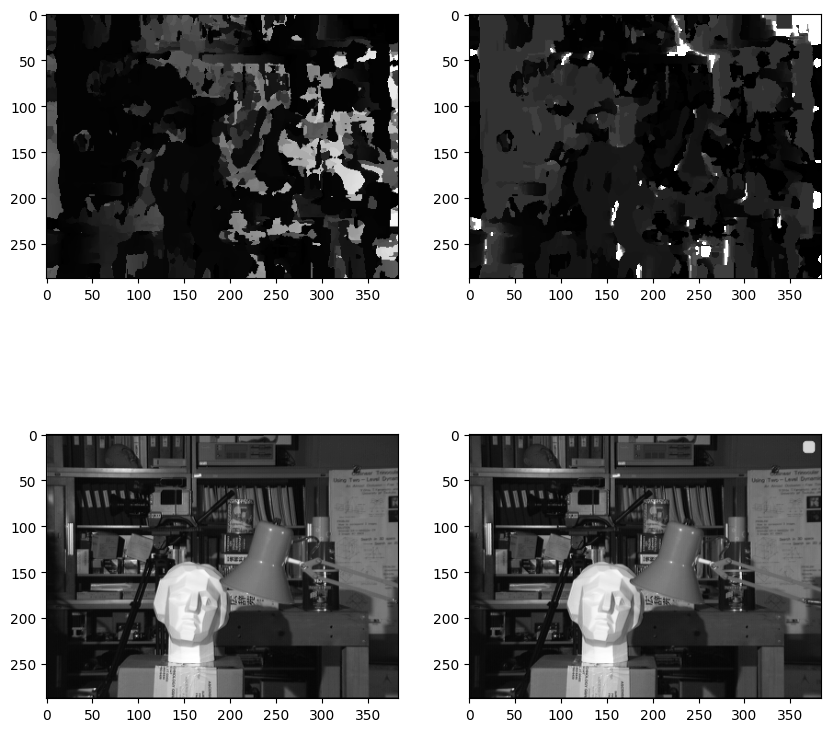

In [47]:
best_disparity_img = best_disparity_matrix
# Now we get depth (although these are the wrong values)
b = 63.1542 # In centimeters
f_x = (386.94+386.13)/2 # getting the average between the two cameras
best_depth_img = (b*f_x)/best_disparity_img
# Now lets show the disparity matrix as an image
# print(best_disparity_img.shape)
# print(best_disparity_img)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(best_disparity_img, cmap="gray")
axs[0, 1].imshow(best_depth_img, cmap="gray")
axs[1, 0].imshow(img_left_gray_crop, cmap="gray")
axs[1, 1].imshow(img_right_gray_crop, cmap="gray")

plt.legend()

plt.show()

In [20]:
depth_img = best_depth_img
disparity_img = best_disparity_img

1. Find dense correspondence between pixels in the images
- Non-trivial, will need an algorithm to go across each horizontal line in the image and find corresponding positions with as little noise (mismatches) as possible
2. Then calculate 

Questions:
- What is the disparity space image. In my mind it is the following: for every pixel in the image we have a matrix of all other pixels in the other image with a value that represents the cost. The disparity is then if we used that pixel as the match between the two images.

In [21]:
# Now that we have these correspondences, we can compute depth

# How to actually calculate disparity

# Algorithm for dense correspondence
# https://learnopencv.com/depth-perception-using-stereo-camera-python-c/ 

# Penn state:
# https://www.cse.psu.edu/~rtc12/CSE486/lecture09.pdf 

# Middlebury taxonomy of stereo algorithms:
# https://vision.middlebury.edu/stereo/taxonomy-IJCV.pdf

# 2011 dense correspondence algorithm with public repo

# More complicated but well done 3D reconstruction algorithm:
# https://ieeexplore.ieee.org/document/5940405 

# Stereo matching algorithm:
# https://www.researchgate.net/publication/220745081_Efficient_Large-Scale_Stereo_Matching 

# Big overview
# https://www.youtube.com/watch?v=kxsvG4sSuvA 0



"""
Next steps:
- DONE: Finish the very basic stereo matching algorithm
    - Create cost function
    - Go through each row pixel by pixel and find the best pixel based on 
    minimizing the cost function
    - Get the pixel it corresponds to the most, compute its disparity, then store it in the
    disparity image
    - Go through image and apply the function to go from disparity to depth
- Figure out if depth is working
- Make sure that image is not getting down-sampled because that would mess up our focal parameters, it doesnt seem down-sampled
- This medium article talks about using a zed-m camera for depth estimation https://medium.com/@gupsekobas/zed-camera-calibration-and-3d-stereo-depth-estimation-2f5eacb1a83e
- Use a chess board to calibrate the ZED-M camera 
- Look into different stereo matching algorith methods, try to implement a local window method and a global window method
    - Cool method: https://www.youtube.com/watch?v=lkD4XW8n1oY 
    - Apparently, this has a special variant of a local method: Bolles, R. C., Baker, H. H., and Hannah, M. J. (1993). The JISCT stereo evaluation. In 
"""

"""
Ask Prof Wloka:
- Is the depth thing working?
- Why is it taking so long? Is there a faster way?
Next steps:
- Debug the depth calculation algorithm manually
    - As in make a picture where you know the depth and make sure the ZED-M camera is giving you back the right depth
- Once you got that working redo the stereo matching algorithm
    - If it still doesn't work it is probably an issue with correspondence, i.e., finding dense features
- Do some optimizations to make it faster

12/1/2023
- Is my understanding of homographies right
- Explain my understanding of semi-global matching / global matching and ask if its right
"""




"\nAsk Prof Wloka:\n- Is the depth thing working?\n- Why is it taking so long? Is there a faster way?\nNext steps:\n- Debug the depth calculation algorithm manually\n    - As in make a picture where you know the depth and make sure the ZED-M camera is giving you back the right depth\n- Once you got that working redo the stereo matching algorithm\n    - If it still doesn't work it is probably an issue with correspondence, i.e., finding dense features\n- Do some optimizations to make it faster\n\n12/1/2023\n- Is my understanding of homographies right\n- Explain my understanding of semi-global matching / global matching and ask if its right\n"